In [1]:
using ControlSystems, LinearAlgebra, Kronecker, SparseArrays, JuMP, Ipopt, OSQP, Plots
const ETC_L1_QP_lib = "./ETC_L1_QP.so"
function call_ETC_L1_QP(L_Q_inv::Array{Float64,2},V::Array{Float64,2}, c::Array{Float64,1}, G::Array{Float64,2}, g::Array{Float64,1}, rho::Array{Float64,1}, epsilon::Float64, m::Int, n::Int)
    y = Array{Float64,1}(undef,m)
    run_time = Array{Float64,}(undef,1)
    ccall(
        (:ETC_L1_QP, ETC_L1_QP_lib),
        Cvoid,
        (Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Ptr{Cdouble}, Cdouble, Cint, Cint, Ptr{Cdouble}, Ptr{Cdouble}),
        L_Q_inv, V, c, G, g, rho, epsilon, m, n, y, run_time
    )
    return y, run_time    
end

call_ETC_L1_QP (generic function with 1 method)

In [2]:
Ts = 0.05
NSim = 200
Np = 20

# Define the continuous-time model
Ac = [-0.0151 -60.5651 0 -32.174;
      -0.0001 -1.3411 0.9929 0;
      0.00018 43.2541 -0.86939 0;
      0 0 1 0]
Bc = [-2.516 -13.136;
     -0.1689 -0.2514;
     -17.251 -1.5766;
     0 0];
Cc = [0 1 0 0;
      0 0 0 1];
Dc = [0 0;
      0 0];
sys = ss(Ac,Bc,Cc,Dc)
model = c2d(sys, Ts)
nx, nu = size(model.B)
A_aug = [model.A model.B;
         zeros(nu,nx) I(nu)]
B_aug = [model.B;
         I(nu)]
C_aug = [model.C zeros(nu,nu)]

# MPC-to-QP condense construction
Wy = 10 * I(nu)
Wdu = 0.1 * I(nu)
AiB = B_aug
BB = kron(I(Np),AiB)
for i in 1:Np-1
    AiB = A_aug * AiB
    BB += kron(spdiagm(-i=>ones(Np-i)),AiB)
end
QQ = kron(I(Np), C_aug'*Wy*C_aug)
RR = kron(I(Np), Wdu)
Q = BB' * QQ * BB + RR
Q = (Q+Q')/2

E_x = [0 1 0 0 0 0;
       0 0 0 1 0 0;
       0 0 0 0 1 0;
       0 0 0 0 0 1]
G = [kron(I(Np), E_x)*BB; -kron(I(Np), E_x)*BB];

In [3]:
# closed-loop simulation using mine L1-QP solver
sleep(1)
ref = [0.0; 10.0]
x = [0; 5; 0; 0] # lies in an infeasible region
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
Run_time_Hist = []
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    x0 = [x; u]
    ei = A_aug * x0
    ee = ei
    gg = E_x*ei
    for i in 2:Np
        ei = A_aug * ei
        ee = [ee; ei]
        gg = [gg; E_x*ei]
    end
    c = BB' * (QQ*ee - vec(repeat(C_aug'*Wy*ref, Np, 1)))
    g = [vec(repeat([0.5;100;25;25],Np,1)) - gg; gg - vec(repeat([-0.5;-100;-25;-25],Np,1))]
    # using our ETC-L1-QP solver
    rho = vec(1000 * [repeat([1.0;1.0;10.0;10.0],Np,1); repeat([1.0;1.0;10.0;10.0],Np,1)])
    Q_chol = cholesky(Q)
    L_Q_inv = Matrix(inv(Q_chol.L))
    V = G*L_Q_inv'
    epsilon = 1e-6
    dU, run_time = call_ETC_L1_QP(L_Q_inv, V, c, G, g, rho, epsilon, length(c), length(g))
    Run_time_Hist = [Run_time_Hist; run_time]
    # apply the first control input
    u = u + dU[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end
worst_case_computation_time = maximum(Run_time_Hist)
println("The wost-case computation of our ETC-L1-QP solver is $worst_case_computation_time seconds")

The wost-case computation of our ETC-L1-QP solver is 0.034774466000000004 seconds


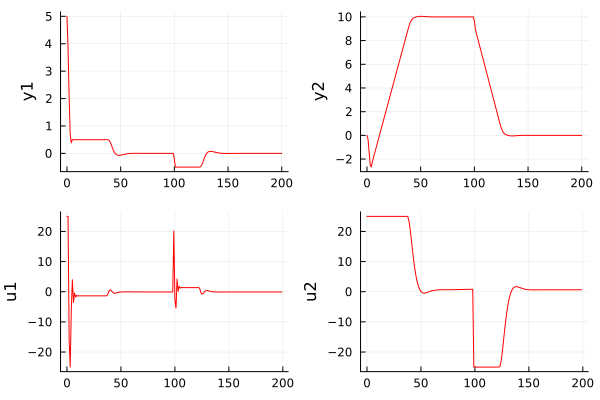

In [4]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)


In [9]:
# closed-loop simulation using Ipopt
sleep(1)
ref = [0.0; 10.0]
x = [0; 5; 0; 0] # lies in an infeasible region
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
Run_time_Hist_Ipopt_L1_QP = []
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    x0 = [x; u]
    ei = A_aug * x0
    ee = ei
    gg = E_x*ei
    for i in 2:Np
        ei = A_aug * ei
        ee = [ee; ei]
        gg = [gg; E_x*ei]
    end
    c = BB' * (QQ*ee - vec(repeat(C_aug'*Wy*ref, Np, 1)))
    g = [vec(repeat([0.5;100;25;25],Np,1)) - gg; gg - vec(repeat([-0.5;-100;-25;-25],Np,1))]

    # using Ipopt to solve L1-QP
    rho = vec(1000 * [repeat([1.0;1.0;10.0;10.0],Np,1); repeat([1.0;1.0;10.0;10.0],Np,1)])
    H = G*inv(Q)*G'
    h = G*inv(Q)*c + g
    model_0 = Model(Ipopt.Optimizer)
    set_attribute(model_0, "print_level", 0)
    @variable(model_0, 0.0 <= z[i=1:length(h)]<= rho[i])
    @objective(model_0, Min, 0.5 * z' * H * z + h'*z)
    optimize!(model_0)
    z_Ipopt_L1_QP = [value(z[i]) for i in 1:length(h)]
    dU = -inv(Q)*(c+G'*z_Ipopt_L1_QP)
    sol_time_Ipopt_L1_QP = MOI.get(model_0, MOI.SolveTimeSec())
    Run_time_Hist_Ipopt_L1_QP = [Run_time_Hist_Ipopt_L1_QP; sol_time_Ipopt_L1_QP]
    # apply the first control input
    u = u + dU[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end
worst_case_computation_time_IPOPT = maximum(Run_time_Hist_Ipopt_L1_QP)
println("The wost-case computation of IPOPT is $worst_case_computation_time_IPOPT seconds")

The wost-case computation of IPOPT is 0.045530080795288086 seconds


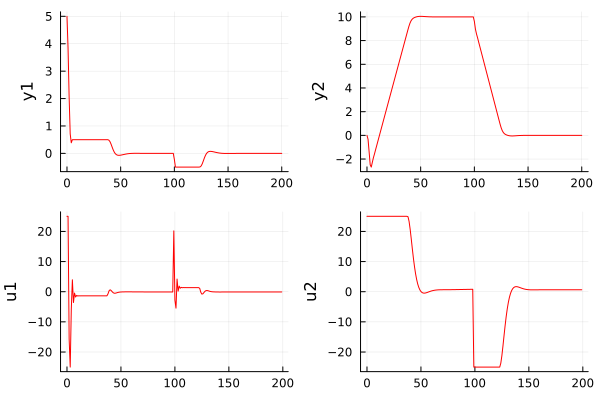

In [10]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)

In [11]:
# closed-loop simulation using OSQP in L1-QP formulation
sleep(1)
ref = [0.0; 10.0]
x = [0; 5; 0; 0] # lies in an infeasible region
u = zeros(nu)
Ref_Hist = ref
U_Hist = Matrix{Float64}(undef, 2, 0)
Y_Hist = model.C*x
Run_time_Hist_OSQP_L1_QP = []
prob = OSQP.Model()
for k in 1:NSim
    if mod(k,100)==0
        ref = [0.0; 0.0]
    end
    Ref_Hist = [Ref_Hist ref]
    # finish uncompleted MPC-to-QP condense construction
    x0 = [x; u]
    ei = A_aug * x0
    ee = ei
    gg = E_x*ei
    for i in 2:Np
        ei = A_aug * ei
        ee = [ee; ei]
        gg = [gg; E_x*ei]
    end
    c = BB' * (QQ*ee - vec(repeat(C_aug'*Wy*ref, Np, 1)))
    g = [vec(repeat([0.5;100;25;25],Np,1)) - gg; gg - vec(repeat([-0.5;-100;-25;-25],Np,1))]
    # using OSQP to solve L1-QP
    rho = vec(1000 * [repeat([1.0;1.0;10.0;10.0],Np,1); repeat([1.0;1.0;10.0;10.0],Np,1)])
    H = G*inv(Q)*G'
    h = G*inv(Q)*c + g
    OSQP.setup!(prob; P=sparse(H), q=h, A=sparse(Diagonal(ones(length(h)))),l=zeros(length(h)),u=rho, eps_abs=1e-6, eps_rel=1e-6, verbose=0)
    res = OSQP.solve!(prob)
    z_OSQP_L1_QP = res.x
    dU = -inv(Q)*(c+G'*z_OSQP_L1_QP)
    sol_time_OSQP_L1_QP = res.info.run_time
    Run_time_Hist_OSQP_L1_QP = [Run_time_Hist_OSQP_L1_QP; sol_time_OSQP_L1_QP]
    # apply the first control input
    u = u + dU[1:nu]
    x = model.A * x + model.B * u
    U_Hist = hcat(U_Hist, u)
    Y_Hist = [Y_Hist model.C*x]
end
worst_case_computation_time_OSQP = maximum(Run_time_Hist_OSQP_L1_QP)
println("The wost-case computation of OSQP is $worst_case_computation_time_OSQP seconds")

The wost-case computation of OSQP is 0.11281579 seconds


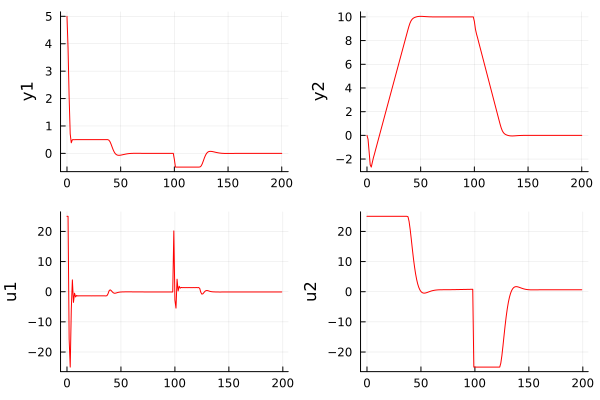

In [12]:
plot_layout = @layout [a b; c d]
p = plot(layout = plot_layout)
plot!(p, 0:NSim, Y_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="y1",subplot=1)
plot!(p, 0:NSim, Y_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="y2",subplot=2)
plot!(p, 0:NSim-1, U_Hist[1,:], label=false, color=:red, linewidth=1,ylabel="u1",subplot=3)
plot!(p, 0:NSim-1, U_Hist[2,:], label=false, color=:red, linewidth=1,ylabel="u2",subplot=4)